In [1]:
import pandas as pd
import numpy as np
import random
from collections import defaultdict
import math

In [2]:
df = pd.read_csv('traffic_signal_data.csv')

state_features = [
    'Vehicles North', 'Vehicles South', 'Vehicles East', 'Vehicles West',
    'Avg Wait Time North', 'Avg Wait Time South', 'Avg Wait Time East', 'Avg Wait Time West'
]

num_bins = 4
bins = {}

for feature in state_features:
    try:
        bins[feature] = pd.qcut(df[feature], q=num_bins, retbins=True, duplicates='drop')[1]
        bins[feature] = np.unique(bins[feature])
        if len(bins[feature]) < 2:
             print(f"Warning: Could not create enough unique bins for {feature}. Using min/max.")
             bins[feature] = np.array([df[feature].min(), df[feature].max()])
        print(f"  Bins for {feature}: {bins[feature]}")
    except Exception as e:
        print(f"Error calculating bins for {feature}: {e}")
        min_val = df[feature].min()
        max_val = df[feature].max()
        if min_val == max_val:
             bins[feature] = np.array([min_val, min_val + 1e-9])
             print(f"  Feature {feature} is constant. Using bins: {bins[feature]}")
        else:
             bins[feature] = np.linspace(min_val, max_val, num_bins + 1)
             bins[feature] = np.unique(bins[feature])
             if len(bins[feature]) < 2:
                 bins[feature] = np.array([min_val, max_val])
             print(f"  Using fallback bins (linspace) for {feature}: {bins[feature]}")

def get_discrete_state(data_row, current_bins):
    discrete_values = []
    if data_row is None: 
        return None
    for feature in state_features:
        val = data_row.get(feature, None)
        if val is None or math.isnan(val):
            discrete_values.append(0)
            continue
        feature_bins = current_bins[feature]
        val_clipped = np.clip(val, feature_bins[0], feature_bins[-1])
        bin_index = np.digitize([val_clipped], feature_bins, right=True)[0]
        final_bin_index = max(0, int(bin_index) - 1) 
        final_bin_index = min(final_bin_index, len(feature_bins) - 2)
        discrete_values.append(final_bin_index)
    return tuple(discrete_values)


  Bins for Vehicles North: [ 0. 12. 25. 36. 49.]
  Bins for Vehicles South: [ 0. 12. 24. 37. 49.]
  Bins for Vehicles East: [ 0. 13. 25. 37. 49.]
  Bins for Vehicles West: [ 0. 12. 25. 37. 49.]
  Bins for Avg Wait Time North: [  0.  29.  59.  89. 119.]
  Bins for Avg Wait Time South: [  0.  29.  60.  89. 119.]
  Bins for Avg Wait Time East: [  0.  30.  59.  88. 119.]
  Bins for Avg Wait Time West: [  0.    29.75  61.    90.25 119.  ]


In [3]:
def calculate_reward(next_data_row):
    if next_data_row is None:
        return 0 
    wait_times = [
        next_data_row.get('Avg Wait Time North', 0),
        next_data_row.get('Avg Wait Time South', 0),
        next_data_row.get('Avg Wait Time East', 0),
        next_data_row.get('Avg Wait Time West', 0)
    ]
    total_wait_time = sum(w if pd.notna(w) else 0 for w in wait_times)
    return -total_wait_time

q_table = defaultdict(lambda: [0.0, 0.0]) # [Q(s, action=0), Q(s, action=1)]

In [7]:
alpha = 0.1          # Learning rate
gamma = 0.9          # Discount factor (slightly lower for potentially noisy offline data)
epsilon = 1.0        # Initial exploration rate
epsilon_decay = 0.998 # Slightly faster decay
min_epsilon = 0.05   # Minimum exploration rate
num_epochs = 1000     # Increased epochs for potentially better convergence view
epoch_rewards_history = []

print("\nStarting Q-Learning Training...")
total_steps = len(df) - 1

for epoch in range(num_epochs):
    current_epsilon = max(min_epsilon, epsilon * (epsilon_decay**epoch))
    epoch_total_reward = 0.0

    for i in range(total_steps):
        current_row = df.iloc[i]
        current_state_discrete = get_discrete_state(current_row, bins)

        if current_state_discrete is None:
            continue

        if random.random() < current_epsilon:
            action = random.choice([0, 1])
        else:
            q_values = q_table[current_state_discrete]
            action = np.argmax(q_values)

        next_row = df.iloc[i+1]
        next_state_discrete = get_discrete_state(next_row, bins)
        reward = calculate_reward(next_row)

        epoch_total_reward += reward

        if next_state_discrete is None:
             continue 

        old_q_value = q_table[current_state_discrete][action]
        next_max_q = np.max(q_table[next_state_discrete])

        new_q_value = old_q_value + alpha * (reward + gamma * next_max_q - old_q_value)
        q_table[current_state_discrete][action] = new_q_value

    epoch_rewards_history.append(epoch_total_reward)

    if (epoch + 1) % 100 == 0 or epoch == 0: # Print less frequently for more epochs
        print(f"Epoch {epoch+1}/{num_epochs} finished. Epsilon: {current_epsilon:.4f}. Total Reward: {epoch_total_reward:.2f}. Q-table size: {len(q_table)}")

print("\nTraining finished.")
print(f"Final Q-table size: {len(q_table)}")


Starting Q-Learning Training...
Epoch 1/1000 finished. Epsilon: 1.0000. Total Reward: -343572.00. Q-table size: 1422
Epoch 100/1000 finished. Epsilon: 0.8202. Total Reward: -343572.00. Q-table size: 1422
Epoch 200/1000 finished. Epsilon: 0.6714. Total Reward: -343572.00. Q-table size: 1422
Epoch 300/1000 finished. Epsilon: 0.5496. Total Reward: -343572.00. Q-table size: 1422
Epoch 400/1000 finished. Epsilon: 0.4499. Total Reward: -343572.00. Q-table size: 1422
Epoch 500/1000 finished. Epsilon: 0.3682. Total Reward: -343572.00. Q-table size: 1422
Epoch 600/1000 finished. Epsilon: 0.3014. Total Reward: -343572.00. Q-table size: 1422
Epoch 700/1000 finished. Epsilon: 0.2467. Total Reward: -343572.00. Q-table size: 1422
Epoch 800/1000 finished. Epsilon: 0.2020. Total Reward: -343572.00. Q-table size: 1422
Epoch 900/1000 finished. Epsilon: 0.1653. Total Reward: -343572.00. Q-table size: 1422
Epoch 1000/1000 finished. Epsilon: 0.1353. Total Reward: -343572.00. Q-table size: 1422

Training f

In [8]:
def get_optimal_action(state_data_row, current_q_table, current_bins):
    discrete_state = get_discrete_state(state_data_row, current_bins)
    if discrete_state is None:
        print("Warning: Could not determine discrete state for input. Returning default action 0.")
        return 0
    if discrete_state not in current_q_table:
        print(f"Warning: State {discrete_state} not seen during training. Returning random action.")
        return random.choice([0, 1])
    else:
        q_values = current_q_table[discrete_state]
        optimal_action = np.argmax(q_values)
        # print(f"State: {discrete_state}, Q-values: {q_values}, Optimal Action: {optimal_action}")
        return optimal_action

# --- Example Usage ---
print("\n--- Example: Getting Optimal Action for Sample States ---")

# Take a few samples from the original data
sample_indices = [0, 50, 100, 500, 1000]
for idx in sample_indices:
    if idx < len(df):
        sample_state_row = df.iloc[idx]
        print(f"\nInput State (Row {idx}):")
        print(sample_state_row[state_features])
        optimal_action = get_optimal_action(sample_state_row, q_table, bins)
        print(f"==> Learned Optimal Action: Phase {optimal_action}")
        print(f"    (Original Data Action was: Phase {int(sample_state_row['Traffic Signal Phase'])})")
    else:
         print(f"\nIndex {idx} out of bounds for dataframe.")


# Demonstrate with a hypothetical state
hypothetical_state = {
    'Vehicles North': 40, 'Vehicles South': 5, 'Vehicles East': 45, 'Vehicles West': 10,
    'Avg Wait Time North': 80, 'Avg Wait Time South': 10, 'Avg Wait Time East': 90, 'Avg Wait Time West': 15
}
print("\nHypothetical State:")
print(hypothetical_state)
optimal_action_hypo = get_optimal_action(hypothetical_state, q_table, bins)
print(f"==> Learned Optimal Action: Phase {optimal_action_hypo}")


--- Example: Getting Optimal Action for Sample States ---

Input State (Row 0):
Vehicles North          38
Vehicles South          11
Vehicles East           29
Vehicles West           29
Avg Wait Time North     39
Avg Wait Time South     41
Avg Wait Time East     118
Avg Wait Time West      38
Name: 0, dtype: int64
==> Learned Optimal Action: Phase 0
    (Original Data Action was: Phase 0)

Input State (Row 50):
Vehicles North          1
Vehicles South         42
Vehicles East          43
Vehicles West          41
Avg Wait Time North    46
Avg Wait Time South    17
Avg Wait Time East     40
Avg Wait Time West     22
Name: 50, dtype: int64
==> Learned Optimal Action: Phase 1
    (Original Data Action was: Phase 0)

Input State (Row 100):
Vehicles North          8
Vehicles South         11
Vehicles East          46
Vehicles West          24
Avg Wait Time North    91
Avg Wait Time South     9
Avg Wait Time East      5
Avg Wait Time West      6
Name: 100, dtype: int64
==> Learned Optimal


--- Visualizing Training Reward ---


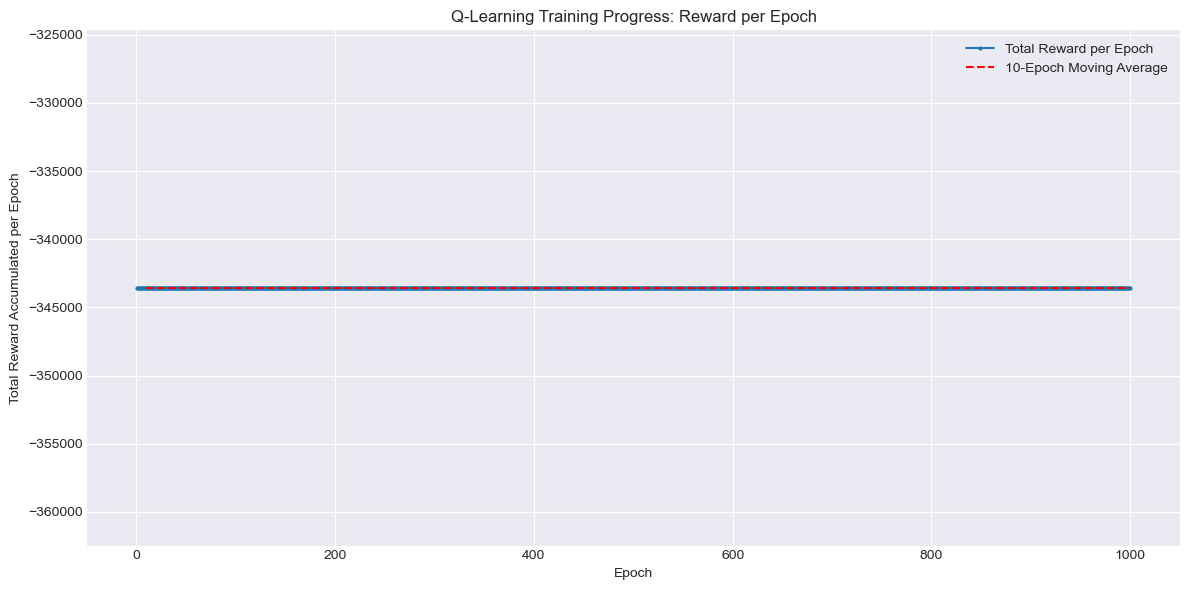

In [9]:
import matplotlib.pyplot as plt

print("\n--- Visualizing Training Reward ---")
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), epoch_rewards_history, marker='.', linestyle='-', markersize=4, label='Total Reward per Epoch')

# Optional: Add a moving average to smooth the plot
window_size = 10
if len(epoch_rewards_history) >= window_size:
    moving_avg = pd.Series(epoch_rewards_history).rolling(window=window_size).mean()
    plt.plot(range(1, num_epochs + 1), moving_avg, linestyle='--', color='red', label=f'{window_size}-Epoch Moving Average')

plt.xlabel("Epoch")
plt.ylabel("Total Reward Accumulated per Epoch")
plt.title("Q-Learning Training Progress: Reward per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()